In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from ordered_set import OrderedSet
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# # download ML1M dataset
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip

In [3]:
# config
# alpha from section 2.3 of paper
alpha = 0.0001

# iterations for random walk
n_iter = 50

# K in RecWalk K-step
K = 20

# eta in RecWalk PR 
eta = 0.99

In [4]:
# preprocessing movies data
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')

In [5]:
# preprocessing ratings data
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

In [6]:
# splitting data into train and validation set 
ratings_df, ratings_val = train_test_split(ratings_df, test_size=0.1, random_state=42)
ratings_df.shape, ratings_val.shape

((900188, 4), (100021, 4))

In [7]:
users_list = ratings_df['userID'].unique().tolist()
movies_list = ratings_df['movieID'].unique().tolist()

n_users = len(users_list)
n_movies = len(movies_list)

# relabelling movieIDs for RecWalk
# relabelling not required for userIDs
movieID2idx = dict(zip(movies_list, range(n_movies)))
idx2movieID = {v:k for k, v in movieID2idx.items()}
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))
ratings_df['movieID'].replace(movieID2idx, inplace=True)

print('Number of Users:', n_users) 
print('Number of Movies:', n_movies)

Number of Users: 6040
Number of Movies: 3694


### Quantization

For purpose of being memory-efficient for running algorithm, we will specify the datatypes specifically as per matrix requirements:
1. **ratings_mat:** The ratings matrix can take values between [1,5], hence datatype of **uint8** should be optimal
2. **R:** R matrix is binary - 0/1, so should be boolean in nature
3. **W:** W is float, can be low-precision format - fp16
4. **AG:** AG matrix is binary - 0/1, so should be boolean
5. **H:** H matrix is float, can be low-precision format - fp16

In [8]:
def get_R_W_mat(ratings_df):
    # mapping users to their rated movies
    interaction_dict = dict(ratings_df.groupby('userID')['movieID'].apply(lambda x: np.array(x)))

    # mapping users to their ratings
    ratings_dict = dict(ratings_df.groupby('userID')['rating'].apply(lambda x: np.array(x)))

    R = np.zeros((n_users, n_movies), dtype='bool')
    ratings_mat = np.zeros((n_users, n_movies), dtype='uint8')

    for userID, movieIDs in interaction_dict.items():
        # highlight interaction
        R[userID-1, movieIDs] = 1
        
        # highlight rating
        ratings_mat[userID-1, movieIDs] = ratings_dict[userID]

    # item-item similarity matrix
    # pairwise cosine similarity
    W = cosine_similarity(ratings_mat.T, ratings_mat.T)
    return R, W

In [9]:
def get_AG_mat(R):
    M1 = np.zeros((n_users, n_users), dtype='bool')
    M2 = np.zeros((n_movies, n_movies), dtype='bool')
    AG = np.vstack((np.hstack((M1, R)), np.hstack((R.T, M2))))
    return AG

In [10]:
def get_H_mat(AG):
    one = np.ones(n_users + n_movies, dtype='bool')
    H = np.linalg.inv(np.diag(AG @ one)) @ AG
    return H

In [11]:
def get_M_mat(W):
    I = np.identity(n_users, dtype='bool')
    N1 = np.zeros((n_users, n_movies), dtype='bool')
    N2 = np.zeros((n_movies, n_users), dtype='bool')

    W_inf = max(np.sum(W, axis=1))
    MI = W / W_inf + np.diag(1 - np.sum(W, axis=1) / W_inf)
    M = np.vstack((np.hstack((I, N1)), np.hstack((N2, MI))))
    return M

In [12]:
def unittests(W, R, AG, H, M, P):
    # checking non-interacted users
    user_idxs = np.where(np.sum(R, axis=1)==0)[0]

    # checking non-interacted movies
    movie_idxs = np.where(np.sum(R, axis=0)==0)[0]

    # ensure rows of R are non-zero
    assert len(user_idxs)==0

    # ensure columns of R are non-zero
    assert len(movie_idxs)==0    

    # ensuring shapes
    assert W.shape==(n_movies, n_movies)
    assert AG.shape == (n_users + n_movies, n_users + n_movies)
    assert H.shape == AG.shape  
    assert M.shape == (n_users + n_movies, n_users + n_movies)  
    assert P.shape == (n_users + n_movies, n_users + n_movies)

In [13]:
def get_P_mat(alpha, ratings_df):
    R, W = get_R_W_mat(ratings_df)
    AG = get_AG_mat(R)
    H = get_H_mat(AG)
    M = get_M_mat(W)
    P = alpha * H + (1-alpha) * M  

    # run unittests
    unittests(W, R, AG, H, M, P)  
    return P

In [14]:
def random_walk(P_user, initial_state, n_iter):
    new_initial_state = initial_state
    NORM = []
    for i in tqdm(range(n_iter)):
        final_state = np.dot(np.transpose(P_user), new_initial_state)
        prev_initial_state = new_initial_state
        new_initial_state = final_state
        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)

        if i!=0 and (i+1)%5==0:
            print(f'L2 Norm at {i+1} iteration..', L2)        
        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Converged at {i+1} iterations..')
            break
    
    plt.plot(NORM)
    plt.title('L2 NORM')
    plt.show()
    return final_state

In [15]:
def recwalk_Kstep(P, K):
    M1 = np.identity(n_users, dtype='bool')
    M2 = np.zeros((n_users, n_movies), dtype='bool')
    M3 = np.zeros((n_movies, n_users), dtype='bool')
    M4 = np.zeros((n_movies, n_movies), dtype='bool')
    teleport_dist = np.vstack((np.hstack((M1, M2)), np.hstack((M3, M4))))
    assert teleport_dist.shape == (n_users + n_movies, n_users + n_movies)
    
    state = teleport_dist.copy()
    for _ in tqdm(range(K)):
        state = np.dot(np.transpose(P), state)
    
    recommendations = state[:n_users, n_users:]
    assert recommendations.shape == (n_users, n_movies)
    return recommendations

def recwalk_PR(P, eta, n_iter):
    M1 = np.identity(n_users, dtype='bool')
    M2 = np.zeros((n_users, n_movies), dtype='bool')
    M3 = np.zeros((n_movies, n_users), dtype='bool')
    M4 = np.zeros((n_movies, n_movies), dtype='bool')
    teleport_dist = np.vstack((np.hstack((M1, M2)), np.hstack((M3, M4))))
    assert teleport_dist.shape == (n_users + n_movies, n_users + n_movies)

    random_surf = np.ones((n_users + n_movies, n_users + n_movies), dtype='bool') / (n_users + n_movies)
    
    print('Running random walk..')
    P_user = P * eta + (1-eta) * random_surf
    limiting_state = random_walk(P_user, teleport_dist, n_iter)
    
    recommendations = limiting_state[:n_users, n_users:]
    assert recommendations.shape == (n_users, n_movies)
    return recommendations

In [16]:
def get_user_predictions(user, recommendations, idx2movieID, rated_movies_dict, commonID_flag):
    # getting predictions based on recwalk scores
    movie_idxs = recommendations[user-1].argsort()[::-1]
    sorted_movies = list(map(lambda x: idx2movieID[x], movie_idxs)) 
    
    # check whether user is in both training and validation set
    if commonID_flag:
        sorted_movies_set = OrderedSet(sorted_movies)
        return list(sorted_movies_set - rated_movies_dict[user])
    else:
        return sorted_movies

def get_predictions(ratings_df, ratings_val, recommendations, idx2movieID):
    """ 
    for users predictions will be made for movies 
    which they have not rated from training set
    """
    
    # check for users present in validation and training set
    commonIDs = set(ratings_val['userID']) and set(ratings_df['userID'])
    uncommonIDs = set(ratings_val['userID']) - set(ratings_df['userID'])

    rated_movies_dict = dict(ratings_df.groupby('userID')['movieID'].apply(lambda x: set(x)))
    
    # sorted set for movies 
    pred = dict(zip(commonIDs, map(lambda x: get_user_predictions(x, recommendations, idx2movieID, rated_movies_dict, 1), commonIDs)))  
    if uncommonIDs:
        pred2 = {}
        pred2 = dict(zip(uncommonIDs, map(lambda x: get_user_predictions(x, recommendations, idx2movieID, rated_movies_dict, 0), uncommonIDs)))
        pred.update(pred2)
    return pred

In [17]:
def get_eval_data(ratings_df, ratings_val, recommendations, idx2movieID):
    gt = {}
    pred = {}
    ratings_val = ratings_val.reset_index(drop=True)

    # getting ground truth data
    for idx in range(len(ratings_val)):
        userID = ratings_val.loc[idx, 'userID']
        movieID = ratings_val.loc[idx, 'movieID']
        rating = ratings_val.loc[idx, 'rating']
        if gt.get(userID):
            gt[userID].append([movieID, rating])
        else:
            gt[userID] = [[movieID, rating]]

    for user, v in gt.items():
        # sorting movies according to ratings
        gt[user] = np.array(sorted(v, key = lambda x: x[1], reverse=True)).astype('int')[:, 0].tolist()  

    # get predictions based on RecWalk K-Step 
    pred = get_predictions(ratings_df, ratings_val, recommendations, idx2movieID)    
    return gt, pred

In [18]:
def hit_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])   
    common_set = act_set & pred_set   
    if (len(common_set)>0):
        return 1
    else:
        return 0
    
def precision_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])    
    common_set = act_set & pred_set   
    if len(pred_set)==0:
        return 0
    else:
        return len(common_set) / len(pred_set)

def recall_k(act, pred, k):
    act_set = set(act)
    pred_set = set(pred[:k])   
    common_set = act_set & pred_set
    if len(act_set)==0:
        return 0
    else:
        return len(common_set) / len(act_set)

def mean_reciprocal_rank_k(act, pred, k):
    found = 0
    for i in range(len(pred)):
        if pred[i] in act[:k]:
            found = 1
            break
    if found:
        mrr = 1 / (i+1)
    else:
        mrr = 0
    return mrr

# overall MRR
def mean_reciprocal_rank(gt, predictions):
    def find_reciprocal_rank(act, pred):
        pred = np.array(pred)
        for p in pred:
            if p in act:
                rank = np.where(pred==p)[0][0] + 1
                return 1/rank
        return 0
    return np.mean(list(map(lambda x, y: find_reciprocal_rank(x, y), gt, predictions)))    

In [19]:
def calculate_scores(metric):    
    values_normalized = []
    for v in metric.values():
        values_normalized.append(v[0]/max(v[1],1))
    return values_normalized

def get_recommendation_metrics(gt, pred):
    hit = {}
    rec = {}
    prec = {}
    mrr = {}

    topK = [5, 10, 20, 50, 100, 200]
    for i in topK:
        hit[i] = [0, 0]
        rec[i] = [0, 0]
        prec[i] = [0, 0]
        mrr[i] = [0, 0]

    for user in gt.keys():
        for topk in rec.keys():
            # if number of predictions are less than topK, skip 
            if len(pred[user])<topk:
                break

            h = hit_k(gt[user], pred[user], topk)
            r = recall_k(gt[user], pred[user], topk)
            p = precision_k(gt[user], pred[user], topk)
            m = mean_reciprocal_rank_k(gt[user], pred[user], topk)

            hit[topk] = [hit[topk][0]+h, hit[topk][1]+1]
            rec[topk] = [rec[topk][0]+r, rec[topk][1]+1]
            prec[topk] = [prec[topk][0]+p, prec[topk][1]+1]
            mrr[topk] = [mrr[topk][0]+m, mrr[topk][1]+1]

    labels=['Precision@K','Recall@K','Hit@K','MRR@K']
    metrics=[prec,rec,hit,mrr]
    df_scores = pd.DataFrame(index=topK, columns=['Precision@K','Recall@K','F1@K','Hit@K','MRR@K'])
    for label, metric in zip(labels, metrics):
        scores = calculate_scores(metric)
        df_scores[label]=scores
    df_scores['F1@K']=(2 * df_scores['Recall@K'] * df_scores['Precision@K'])/(df_scores['Recall@K'] + df_scores['Precision@K'])
    df_scores = df_scores.reset_index()
    df_scores.rename(columns={'index':'K'}, inplace=True)
    return df_scores

In [20]:
def return_plot(df_scores,label):
    X=df_scores.K
    Y=df_scores[label].values
    
    plt.title(f'{label}')
    plt.xlabel('K')
    plt.ylabel('Values')
    plt.xticks(X)
    plt.plot(X,Y,c='k',linestyle='--',marker='o')
    return plt

def plotting(df_scores):
    fig=plt.figure(figsize=(17, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt1 = return_plot(df_scores,'Precision@K')
    plt.subplot(132)
    plt2 = return_plot(df_scores,'Recall@K')
    plt.subplot(133)
    plt3 = return_plot(df_scores,'F1@K')
    plt.show()

    fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt4 = return_plot(df_scores,'Hit@K')
    plt.subplot(122)
    plt5 = return_plot(df_scores,'MRR@K')
    plt.show()

In [21]:
def run(method_K_step):
    # transition probability matrix
    print('Getting transition matrix..')
    P = get_P_mat(alpha, ratings_df)

    # transition matrix through RecWalk K-step or PR method
    print('Generating recommendations..')
    if method_K_step:
        recommendations = recwalk_Kstep(P, K)
    else:
        recommendations = recwalk_PR(P, eta, n_iter)

    # building ground-truth and prediction dictionaries
    print('Getting evaluation data..\n')
    gt, pred = get_eval_data(ratings_df, ratings_val, recommendations, idx2movieID)

    df_scores = get_recommendation_metrics(gt, pred)
    print('Recommendation metrics..')
    print(df_scores,'\n')

    # getting overall MRR
    user_rated_movies = list(gt.values())
    predictions = list(pred.values())
    print('Overall MRR: ', mean_reciprocal_rank(user_rated_movies, predictions))

    plotting(df_scores)

Getting transition matrix..
Generating recommendations..


100%|██████████| 20/20 [02:42<00:00,  8.10s/it]


Getting evaluation data..

Recommendation metrics..
     K  Precision@K  Recall@K      F1@K     Hit@K     MRR@K
0    5     0.004054  0.001268  0.001932  0.019765  0.006764
1   10     0.004054  0.002613  0.003177  0.038861  0.010796
2   20     0.004824  0.005544  0.005159  0.085930  0.015427
3   50     0.005906  0.017255  0.008800  0.223618  0.019721
4  100     0.006358  0.037356  0.010867  0.377387  0.020799
5  200     0.005871  0.068004  0.010809  0.519095  0.020869 

Overall MRR:  0.02032117249935793


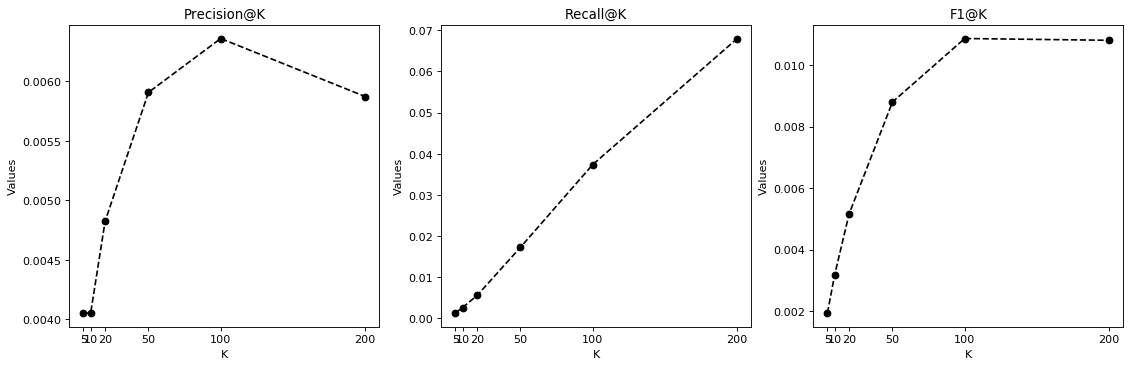

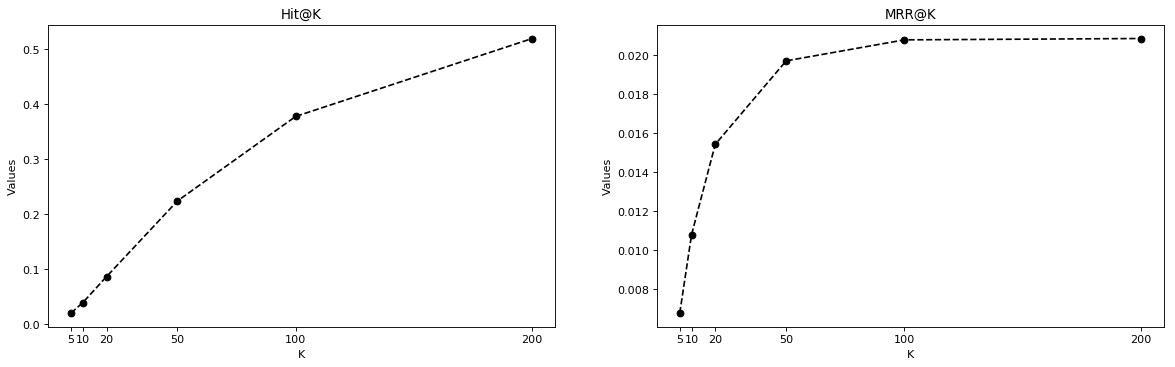

In [22]:
# RecWalk K-step
run(method_K_step=True)

Getting transition matrix..
Generating recommendations..
Running random walk..


  8%|▊         | 4/50 [00:38<07:27,  9.73s/it]

L2 Norm at 5 iteration.. 0.7541383648190388


 18%|█▊        | 9/50 [01:27<06:41,  9.79s/it]

L2 Norm at 10 iteration.. 0.7168295611186304


 28%|██▊       | 14/50 [02:21<06:23, 10.66s/it]

L2 Norm at 15 iteration.. 0.6814897952538904


 38%|███▊      | 19/50 [03:12<05:24, 10.48s/it]

L2 Norm at 20 iteration.. 0.6479924813592413


 48%|████▊     | 24/50 [04:04<04:30, 10.39s/it]

L2 Norm at 25 iteration.. 0.6162647271262572


 58%|█████▊    | 29/50 [04:55<03:35, 10.24s/it]

L2 Norm at 30 iteration.. 0.5862520091385869


 68%|██████▊   | 34/50 [05:46<02:40, 10.05s/it]

L2 Norm at 35 iteration.. 0.5579181653993162


 78%|███████▊  | 39/50 [06:36<01:50, 10.00s/it]

L2 Norm at 40 iteration.. 0.5312488581847875


 88%|████████▊ | 44/50 [07:27<01:00, 10.06s/it]

L2 Norm at 45 iteration.. 0.5062570603611369


 98%|█████████▊| 49/50 [08:17<00:09,  9.93s/it]

L2 Norm at 50 iteration.. 0.4829907034375496


100%|██████████| 50/50 [08:27<00:00, 10.16s/it]


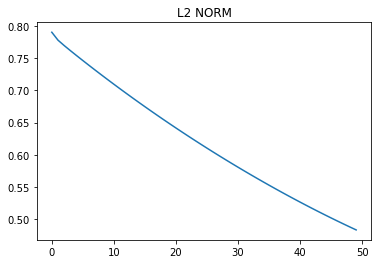

Getting evaluation data..

Recommendation metrics..
     K  Precision@K  Recall@K      F1@K     Hit@K     MRR@K
0    5     0.004054  0.001268  0.001932  0.019765  0.006764
1   10     0.004054  0.002613  0.003177  0.038861  0.010796
2   20     0.004824  0.005544  0.005159  0.085930  0.015427
3   50     0.005906  0.017255  0.008800  0.223618  0.019721
4  100     0.006358  0.037356  0.010867  0.377387  0.020799
5  200     0.005871  0.068004  0.010809  0.519095  0.020869 

Overall MRR:  0.02032117249935793


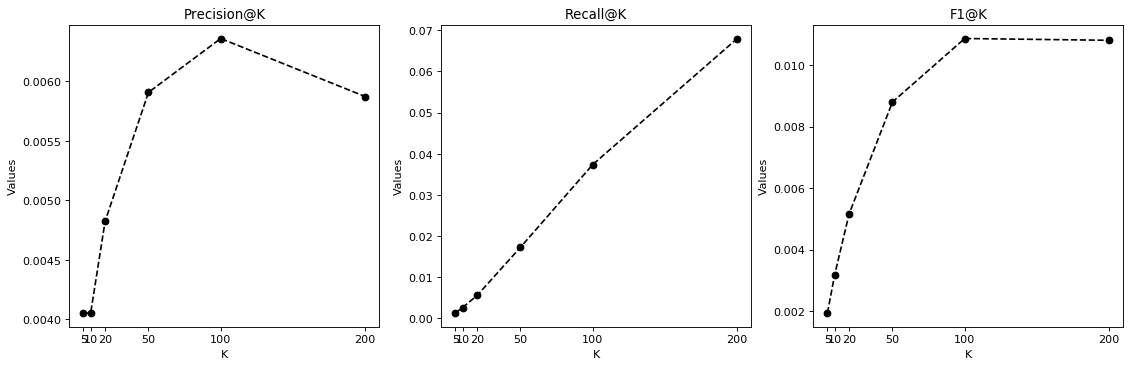

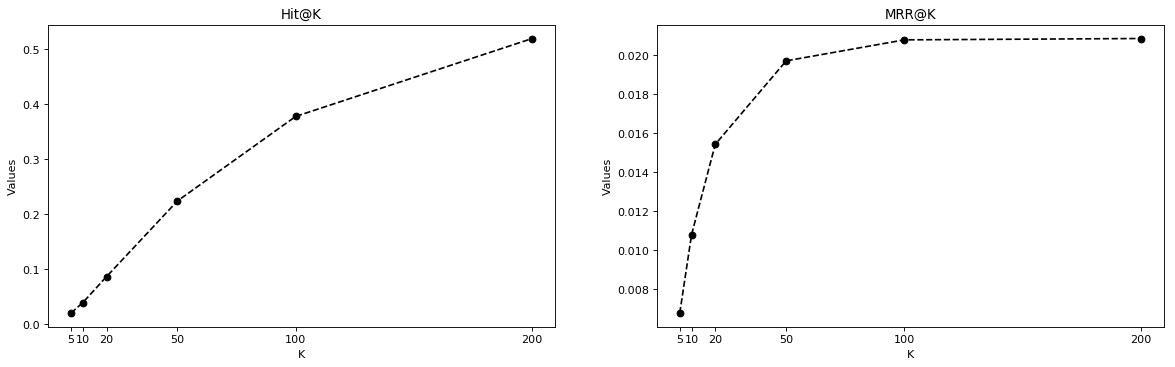

In [23]:
# RecWalk PR
run(method_K_step=False)